# This notebook contains some small tasks for a data science course

# 1. Extracting and Visualizing Stock Data


In [1]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [7]:
tesla = yf.Ticker("TSLA")
tesla_data = tesla.history(period="max")
tesla_data.reset_index(inplace=True)
tesla_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2010-06-29,1.266667,1.666667,1.169333,1.592667,281494500,0,0.0
1,2010-06-30,1.719333,2.028000,1.553333,1.588667,257806500,0,0.0
2,2010-07-01,1.666667,1.728000,1.351333,1.464000,123282000,0,0.0
3,2010-07-02,1.533333,1.540000,1.247333,1.280000,77097000,0,0.0
4,2010-07-06,1.333333,1.333333,1.055333,1.074000,103003500,0,0.0


In [8]:
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-PY0220EN-SkillsNetwork/labs/project/revenue.htm"

html_data = requests.get(url).text
soup = BeautifulSoup(html_data, 'html5lib')

tables = soup.find_all('table')
for index,table in enumerate(tables):
    if ("Tesla Quarterly Revenue" in str(table)):
        table_index = index
        
tesla_revenue = pd.read_html(str(tables[table_index]), flavor='bs4')[0]
tesla_revenue.columns =["Date", "Revenue"]
tesla_revenue.head()

,Date,Revenue
0,2022-09-30,"$21,454"
1,2022-06-30,"$16,934"
2,2022-03-31,"$18,756"
3,2021-12-31,"$17,719"
4,2021-09-30,"$13,757"


In [9]:
tesla_revenue["Revenue"] = tesla_revenue['Revenue'].str.replace(',|\$',"")

tesla_revenue.dropna(inplace=True)

tesla_revenue = tesla_revenue[tesla_revenue['Revenue'] != ""]


/tmp/ipykernel_7299/4082117503.py:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [12]:
def make_graph(stock_data, revenue_data, stock):
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=("Historical Share Price", "Historical Revenue"), vertical_spacing = .3)
    stock_data_specific = stock_data[stock_data.Date <= '2021--06-14']
    revenue_data_specific = revenue_data[revenue_data.Date <= '2021-04-30']
    fig.add_trace(go.Scatter(x=pd.to_datetime(stock_data_specific.Date, infer_datetime_format=True), y=stock_data_specific.Close.astype("float"), name="Share Price"), row=1, col=1)
    fig.add_trace(go.Scatter(x=pd.to_datetime(revenue_data_specific.Date, infer_datetime_format=True), y=revenue_data_specific.Revenue.astype("float"), name="Revenue"), row=2, col=1)
    fig.update_xaxes(title_text="Date", row=1, col=1)
    fig.update_xaxes(title_text="Date", row=2, col=1)
    fig.update_yaxes(title_text="Price ($US)", row=1, col=1)
    fig.update_yaxes(title_text="Revenue ($US Millions)", row=2, col=1)
    fig.update_layout(showlegend=False, height=900, title=stock, xaxis_rangeslider_visible=True)
    fig.show()

In [11]:
make_graph(tesla_data, tesla_revenue, 'Tesla')

# 2. Housing prices


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
%matplotlib inline

In [22]:
file_name="kc_house_data_NaN.csv"

df = pd.read_csv(file_name)
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,20141013T000000,221900.0,3.0,1.00,1180,5650,1.0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,20141209T000000,538000.0,3.0,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,5631500400,20150225T000000,180000.0,2.0,1.00,770,10000,1.0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,3,2487200875,20141209T000000,604000.0,4.0,3.00,1960,5000,1.0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,20150218T000000,510000.0,3.0,2.00,1680,8080,1.0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [23]:
# Check the data
df.dtypes

Unnamed: 0         int64
id                 int64
date              object
price            float64
bedrooms         float64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [24]:
df.describe()

,Unnamed: 0,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21613.00000,2.161300e+04,2.161300e+04,21600.000000,21603.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,...,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,10806.00000,4.580302e+09,5.400881e+05,3.372870,2.115736,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,...,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,6239.28002,2.876566e+09,3.671272e+05,0.926657,0.768996,918.440897,4.142051e+04,0.539989,0.086517,0.766318,...,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,0.00000,1.000102e+06,7.500000e+04,1.000000,0.500000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,...,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,5403.00000,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,...,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,10806.00000,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,...,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,16209.00000,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,...,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,21612.00000,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,...,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [25]:
# Drop useless columns
df.drop(["id", "Unnamed: 0"], axis=1, inplace=True)

In [36]:
print("number of NaN values for the column bedrooms :", df['bedrooms'].isnull().sum())
print("number of NaN values for the column bathrooms :", df['bathrooms'].isnull().sum())

number of NaN values for the column bedrooms : 0
number of NaN values for the column bathrooms : 0


In [35]:
# Replace NaN values with the mean
mean=df['bathrooms'].mean()
df['bathrooms'].replace(np.nan,mean, inplace=True)

mean=df['bedrooms'].mean()
df['bedrooms'].replace(np.nan,mean, inplace=True)

In [28]:
df.value_counts(["floors"]).to_frame()

,0
floors,
1.0,10680
2.0,8241
1.5,1910
3.0,613
2.5,161
3.5,8


<AxesSubplot:xlabel='waterfront', ylabel='price'>

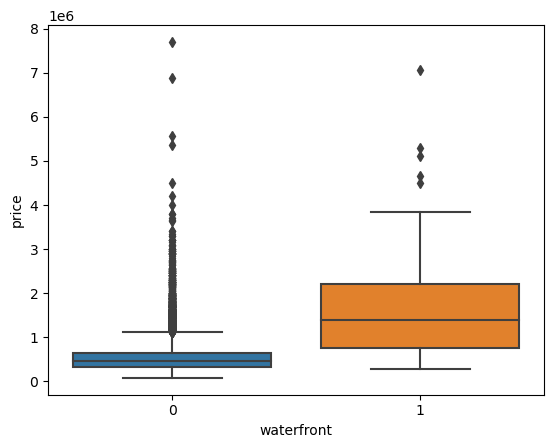

In [29]:
sns.boxplot(x=df["waterfront"], y=df["price"])

<AxesSubplot:xlabel='sqft_above', ylabel='price'>

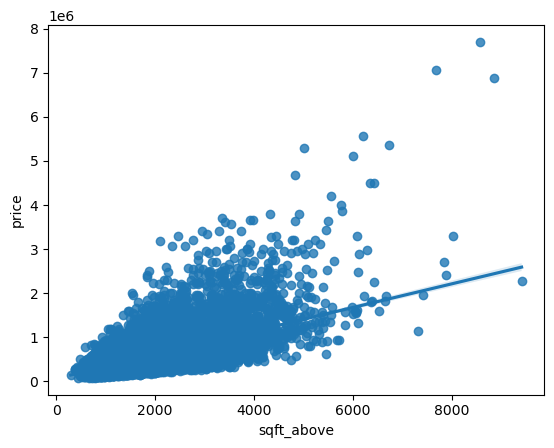

In [30]:
sns.regplot(x=df["sqft_above"], y=df["price"])

In [31]:
df.corr()['price'].sort_values()

zipcode         -0.053203
long             0.021626
condition        0.036362
yr_built         0.054012
sqft_lot15       0.082447
sqft_lot         0.089661
yr_renovated     0.126434
floors           0.256794
waterfront       0.266369
lat              0.307003
bedrooms         0.308890
sqft_basement    0.323816
view             0.397293
bathrooms        0.525738
sqft_living15    0.585379
sqft_above       0.605567
grade            0.667434
sqft_living      0.702035
price            1.000000
Name: price, dtype: float64

In [32]:
# Linear regression model for size of house
X = df[['sqft_living']]
Y = df['price']
lm = LinearRegression()
lm.fit(X,Y)
lm.score(X, Y)

0.4928532179037931

In [37]:
# Same model but for more features
features =["floors", "waterfront","lat" ,"bedrooms" ,"sqft_basement" ,"view" ,"bathrooms","sqft_living15","sqft_above","grade","sqft_living"]     
X = df[features]
Y = df['price']
lm = LinearRegression()
lm.fit(X,Y)
lm.score(X, Y)

0.6576951666037502

In [38]:
# Pipeline
Input=[('scale',StandardScaler()),('polynomial', PolynomialFeatures(include_bias=False)),('model',LinearRegression())]
pipe=Pipeline(Input)
pipe.fit(df[features], df["price"])
pipe.score(df[features], df["price"])

0.7513406905914715

In [39]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

features =["floors", "waterfront","lat" ,"bedrooms" ,"sqft_basement" ,"view" ,"bathrooms","sqft_living15","sqft_above","grade","sqft_living"]    
X = df[features]
Y = df['price']

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)

print("number of test samples:", x_test.shape[0])
print("number of training samples:",x_train.shape[0])

number of test samples: 3242
number of training samples: 18371


In [40]:
from sklearn.linear_model import Ridge

RidgeModel=Ridge(alpha=0.1)
RidgeModel.fit(x_train, y_train)
RidgeModel.score(x_test, y_test)

0.6811402427429836

In [41]:
pr=PolynomialFeatures(degree=2)
x_train_pr=pr.fit_transform(x_train)
x_test_pr=pr.fit_transform(x_test)

RidgeModel=Ridge(alpha=0.1)
RidgeModel.fit(x_train_pr, y_train)
RidgeModel.score(x_test_pr, y_test)

0.7526154324442428

# 3. Australia weather analysis

In [42]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, accuracy_score
import sklearn.metrics as metrics

In [43]:
df = pd.read_csv("Weather_Data.csv")
df.head()

,Date,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2/1/2008,19.5,22.4,15.6,6.2,0.0,W,41,S,SSW,...,92,84,1017.6,1017.4,8,8,20.7,20.9,Yes,Yes
1,2/2/2008,19.5,25.6,6.0,3.4,2.7,W,41,W,E,...,83,73,1017.9,1016.4,7,7,22.4,24.8,Yes,Yes
2,2/3/2008,21.6,24.5,6.6,2.4,0.1,W,41,ESE,ESE,...,88,86,1016.7,1015.6,7,8,23.5,23.0,Yes,Yes
3,2/4/2008,20.2,22.8,18.8,2.2,0.0,W,41,NNE,E,...,83,90,1014.2,1011.8,8,8,21.4,20.9,Yes,Yes
4,2/5/2008,19.7,25.7,77.4,4.8,0.0,W,41,NNE,W,...,88,74,1008.3,1004.8,8,8,22.5,25.5,Yes,Yes


Perform one-hot encoding to transform the categorical variables


In [44]:
df_sydney_processed = pd.get_dummies(data=df, columns=['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm'])

df_sydney_processed.replace(['No', 'Yes'], [0,1], inplace=True)

In [45]:
df_sydney_processed.drop('Date',axis=1,inplace=True)
df_sydney_processed = df_sydney_processed.astype(float)

features = df_sydney_processed.drop(columns='RainTomorrow', axis=1)
Y = df_sydney_processed['RainTomorrow']
df_sydney_processed.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,19.5,22.4,15.6,6.2,0.0,41.0,17.0,20.0,92.0,84.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,19.5,25.6,6.0,3.4,2.7,41.0,9.0,13.0,83.0,73.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21.6,24.5,6.6,2.4,0.1,41.0,17.0,2.0,88.0,86.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,20.2,22.8,18.8,2.2,0.0,41.0,22.0,20.0,83.0,90.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19.7,25.7,77.4,4.8,0.0,41.0,11.0,6.0,88.0,74.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Linear regression

In [46]:
x_train, x_test, y_train, y_test = train_test_split(features, Y, test_size=0.2)
LinearReg = LinearRegression()
LinearReg.fit(x_train, y_train)
predictions = LinearReg.predict(x_test)

LinearRegression_MAE = metrics.mean_absolute_error(y_test, predictions)
LinearRegression_MSE = metrics.mean_squared_error(y_test, predictions)
LinearRegression_R2 = metrics.r2_score(y_test, predictions)

dataa = [['MAE', LinearRegression_MAE], ['MSE', LinearRegression_MSE], ['R2', LinearRegression_R2]]
Report = pd.DataFrame(dataa, columns=['Metric', 'Score'])
Report

,Metric,Score
0,MAE,0.258967
1,MSE,0.118563
2,R2,0.378282


#### KNN

In [47]:
KNN = KNeighborsClassifier(n_neighbors = 4)
KNN.fit(x_train,y_train)
predictions = KNN.predict(x_test)
KNN_Accuracy_Score = metrics.accuracy_score(y_test, predictions)
KNN_JaccardIndex = jaccard_score(y_test, predictions)
KNN_F1_Score = f1_score(y_test, predictions)
print("Accuracy: ", KNN_Accuracy_Score)
print("Jaccard: ", KNN_JaccardIndex)
print("F1 Score: ", KNN_F1_Score)

Accuracy:  0.816793893129771
Jaccard:  0.3717277486910995
F1 Score:  0.5419847328244275


/home/jere/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning:

Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.



#### Decision Trees

In [48]:
Tree = DecisionTreeClassifier(criterion="entropy", max_depth = 5)
Tree.fit(x_train, y_train)
predictions = Tree.predict(x_test)
Tree_Accuracy_Score = accuracy_score(y_test, predictions)
Tree_JaccardIndex = jaccard_score(y_test, predictions)
Tree_F1_Score = f1_score(y_test, predictions)
print("Accuracy: ", Tree_Accuracy_Score)
print("Jaccard: ", Tree_JaccardIndex)
print("F1 Score: ", Tree_F1_Score)

Accuracy:  0.8259541984732824
Jaccard:  0.4213197969543147
F1 Score:  0.5928571428571429


#### Logistic regression

In [49]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(x_train,y_train)
predictions = LR.predict(x_test)
LR_Accuracy_Score = accuracy_score(y_test, predictions)
LR_JaccardIndex = jaccard_score(y_test, predictions)
LR_F1_Score = f1_score(y_test, predictions)
LR_Log_Loss = log_loss(y_test, predictions)
print("Accuracy: ", LR_Accuracy_Score)
print("Jaccard: ", LR_JaccardIndex)
print("F1 Score: ", LR_F1_Score)
print("Log Loss: ", LR_Log_Loss)

Accuracy:  0.8396946564885496
Jaccard:  0.47761194029850745
F1 Score:  0.6464646464646464
Log Loss:  5.536790699512699


#### SVM

In [50]:
SVM = svm.SVC(kernel='linear')
SVM.fit(x_train, y_train) 
predictions = SVM.predict(x_test)
SVM_Accuracy_Score = accuracy_score(y_test, predictions)
SVM_JaccardIndex = jaccard_score(y_test, predictions)
SVM_F1_Score = f1_score(y_test, predictions) 
print("Accuracy: ", SVM_Accuracy_Score)
print("Jaccard: ", SVM_JaccardIndex)
print("F1 Score: ", SVM_F1_Score)

Accuracy:  0.8473282442748091
Jaccard:  0.494949494949495
F1 Score:  0.6621621621621622


In [51]:
dataa = [['Accuracy', KNN_Accuracy_Score, Tree_Accuracy_Score, LR_Accuracy_Score, SVM_Accuracy_Score], \
         ['Jaccard',  KNN_JaccardIndex, Tree_JaccardIndex, LR_JaccardIndex, SVM_JaccardIndex], \
         ['F1 Score', KNN_F1_Score, Tree_F1_Score, LR_F1_Score, SVM_F1_Score], \
         ['Log Loss', 'NA', 'NA',  LR_Log_Loss, 'NA']]
Report = pd.DataFrame(dataa, columns=['Metric', 'KNN', 'Decision Tree', 'Logistic Regression', 'SVM'])
Report

,Metric,KNN,Decision Tree,Logistic Regression,SVM
0,Accuracy,0.816794,0.825954,0.839695,0.847328
1,Jaccard,0.371728,0.42132,0.477612,0.494949
2,F1 Score,0.541985,0.592857,0.646465,0.662162
3,Log Loss,NA,NA,5.536791,NA
